In [55]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable, grad
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import matplotlib.pyplot as plt
import numpy as np
import time
import copy
torch.manual_seed(0)

Files already downloaded and verified
Files already downloaded and verified
 deer   cat truck plane


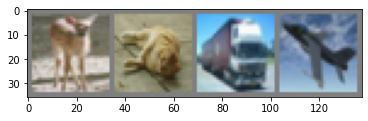

In [56]:
transform = transforms.Compose(
	[transforms.ToTensor(),
	transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
										download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
											shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
										download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
										shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
			'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
plt.show()

In [65]:
history_loss = []
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        """
        Function to predict data's classification
        args : neural net, data
        output : prediction
        """
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def partial_grad(self, data, target, loss_function):
        """
        Function to compute the grad
        args : data, target, loss_function
        return loss
        """
        outputs = self.forward(data)
        loss = loss_function(outputs, target)
        loss.backward() #compute grad
        #print(loss.data.item())
        return loss
    
    def calculate_loss_grad(self, dataset, loss_function, n_samples):
        """
        Function to compute the full loss and the full gradient
        args : dataset, loss function and number of samples
        return : total loss and full grad norm
        """
        total_loss = 0.0
        full_grad = 0.0
        for i_grad, data_grad in enumerate(dataset):
            inputs, labels = data_grad 
            inputs, labels = Variable(inputs), Variable(labels) #wrap data and target into variable
            #print(len(inputs),labels)
            total_loss += (1./n_samples) * self.partial_grad(inputs, labels, loss_function).data.item()
        
        for para in self.parameters():
            full_grad += para.grad.data.norm(2)**2
        
        return total_loss, (1./n_samples) * np.sqrt(full_grad)
    
    def svrg_backward(self, dataset, loss_function, n_epoch, learning_rate):
        """
        Function to updated weights with a SVRG backpropagation
        args : dataset, loss function, number of epochs, learning rate
        return : total_loss_epoch, grad_norm_epoch
        """
        total_loss_epoch = [0 for i in range(n_epoch)]
        grad_norm_epoch = [0 for i in range(n_epoch)]
        for epoch in range(n_epoch):
            running_loss = 0.0
            previous_net_sgd = copy.deepcopy(self) #update previous_net_sgd
            previous_net_grad = copy.deepcopy(self) #update previous_net_grad

            #Compute full grad
            previous_net_grad.zero_grad() # grad = 0
            total_loss_epoch[epoch], grad_norm_epoch[epoch] = previous_net_grad.calculate_loss_grad(dataset, loss_function, n_samples)
            print(total_loss_epoch[epoch], grad_norm_epoch[epoch])
            #Run over the dataset
            for i_data, data in enumerate(dataset):
                inputs, labels = data
                inputs, labels = Variable(inputs), Variable(labels) #wrap data and target into variable
                
                #Compute prev stoc grad
                previous_net_sgd.zero_grad() #grad = 0
                prev_loss = previous_net_sgd.partial_grad(inputs, labels, loss_function)
                
                #Compute cur stoc grad
                self.zero_grad() #grad = 0
                cur_loss = self.partial_grad(inputs, labels, loss_function)
                
                #Backward
                for param1, param2, param3 in zip(self.parameters(), previous_net_sgd.parameters(), previous_net_grad.parameters()): 
                    param1.data -= (learning_rate) * (param1.grad.data - param2.grad.data + (1./n_samples) * param3.grad.data)

                # print statistics
                running_loss += cur_loss.data.item()
                if i_data % 2500 == 2499:    # print every 2500 mini-batches
                    print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i_data + 1, running_loss / 2500))
                    history_loss.append(running_loss / 2500)
                    running_loss = 0.0
                
        return total_loss_epoch, grad_norm_epoch

In [66]:
net = Net()
criterion = nn.CrossEntropyLoss()
n_epoch = 2
learning_rate = 0.01
start = time.time()
n_samples = len(trainloader)
print(n_samples)
total_loss_epoch, grad_norm_epoch = net.svrg_backward(trainloader, criterion, n_epoch, learning_rate)

end = time.time()
print('time is : ', end - start)
print('Finished Training')
print(history_loss)

12500
2.3043568963432364 tensor(0.0379)
[1,  2500] loss: 2.093
[1,  5000] loss: 1.693
[1,  7500] loss: 1.573
[1, 10000] loss: 1.508
[1, 12500] loss: 1.454
1.4047969660752944 tensor(1.1703)
[2,  2500] loss: 1.300
[2,  5000] loss: 1.257
[2,  7500] loss: 1.227
[2, 10000] loss: 1.233
[2, 12500] loss: 1.212
time is :  137.3088026046753
Finished Training
[2.093110364484787, 1.6932030359745025, 1.5732560231804849, 1.5079303756475448, 1.454403892403841, 1.2996312702476978, 1.257473186004162, 1.2268871275603772, 1.232823876491189, 1.212338026021421]


GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship  ship plane
Accuracy of the network on the 10000 test images: 57 %
Accuracy of plane : 65 %
Accuracy of   car : 61 %
Accuracy of  bird : 32 %
Accuracy of   cat : 41 %
Accuracy of  deer : 44 %
Accuracy of   dog : 43 %
Accuracy of  frog : 66 %
Accuracy of horse : 75 %
Accuracy of  ship : 70 %
Accuracy of truck : 68 %


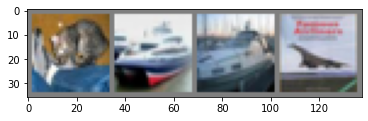

In [67]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

outputs = net(Variable(images))
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

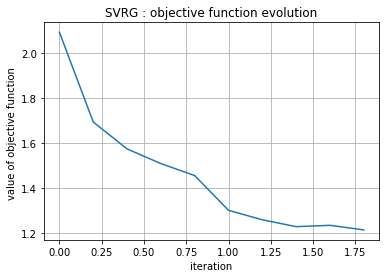

"\nplt.plot(epoch_abs, grad_norm_epoch,'ro')\nplt.xlabel('iteration')\nplt.ylabel('gradient norm')\nplt.title('SVRG : grad norm evolution')\nplt.grid()\nplt.legend(loc=1)\nplt.savefig('SVRG2.png')\nplt.show()\n"

In [71]:
epoch_abs = [0.2*i for i in range(len(history_loss))]
#print(epoch_abs, total_loss_epoch)
plt.plot(epoch_abs, history_loss)
plt.xlabel('iteration')
plt.ylabel('value of objective function ')
plt.title('SVRG : objective function evolution')
plt.grid()
plt.savefig('SVRG1.png')
plt.show()
'''
plt.plot(epoch_abs, grad_norm_epoch,'ro')
plt.xlabel('iteration')
plt.ylabel('gradient norm')
plt.title('SVRG : grad norm evolution')
plt.grid()
plt.legend(loc=1)
plt.savefig('SVRG2.png')
plt.show()
'''